## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 243 kB 46.7 MB/s 


In [35]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [6]:
def get_a_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [7]:
tweets, labels = get_a_tweet(train)

In [8]:
tweets[15],labels[15]

('i do not feel reassured anxiety is on each side', 'joy')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>') #all the words that aren't in the most frequent words are tokenized as <UNK>
tokenizer.fit_on_texts(tweets) #creates a mapping from words to numerical tokens


In [11]:
tokenizer.texts_to_sequences(['what a wonderful day']) #prints numerical values of words in the sentence

[[54, 7, 353, 97]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

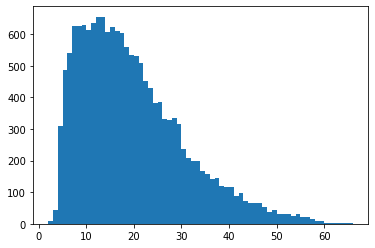

In [12]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
max_len=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded_sequences=pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) #???
  return padded_sequences

In [15]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes=set(labels)
print(classes)

{'love', 'surprise', 'joy', 'sadness', 'fear', 'anger'}


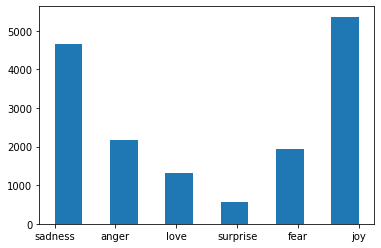

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [50]:
class_to_index=dict((c,i) for i,c in enumerate(classes) )
index_to_class=dict((v,k)for k,v in class_to_index.items())

In [28]:
class_to_index

{'anger': 5, 'fear': 4, 'joy': 2, 'love': 0, 'sadness': 3, 'surprise': 1}

In [29]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'joy', 3: 'sadness', 4: 'fear', 5: 'anger'}

In [30]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])
#lambda functions in python are anonymous functions ...

In [33]:
train_labels=names_to_ids(labels)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [38]:
from tensorflow import keras as k

In [39]:
#need to review and better understand this cell
model=k.models.Sequential([
                           k.layers.Embedding(10000, 16, input_length=max_len),
                           k.layers.Bidirectional(k.layers.LSTM(20, return_sequences=True)),
                           k.layers.Bidirectional(k.layers.LSTM(20)),
                           k.layers.Dense(6, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [41]:
val_tweets, val_labels=get_a_tweet(val)
val_seq=get_sequences(tokenizer, val_tweets)
val_labels=names_to_ids(val_labels)

In [42]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [43]:
from gc import callbacks
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               k.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 60ms/step - loss: 1.2571 - accuracy: 0.5046 - val_loss: 0.7434 - val_accuracy: 0.7105
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5726 - accuracy: 0.7696 - val_loss: 0.5938 - val_accuracy: 0.7840
Epoch 3/20
500/500 [==============================] - 28s 57ms/step - loss: 0.3677 - accuracy: 0.8721 - val_loss: 0.6319 - val_accuracy: 0.7855
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2498 - accuracy: 0.9209 - val_loss: 0.4507 - val_accuracy: 0.8615
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1920 - accuracy: 0.9403 - val_loss: 0.4708 - val_accuracy: 0.8535
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1542 - accuracy: 0.9529 - val_loss: 0.4098 - val_accuracy: 0.8790
Epoch 7/20
500/500 [==============================] - 28s 57ms/step - loss: 0.1234 - accuracy: 0.9639 - val_loss: 0.4274 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

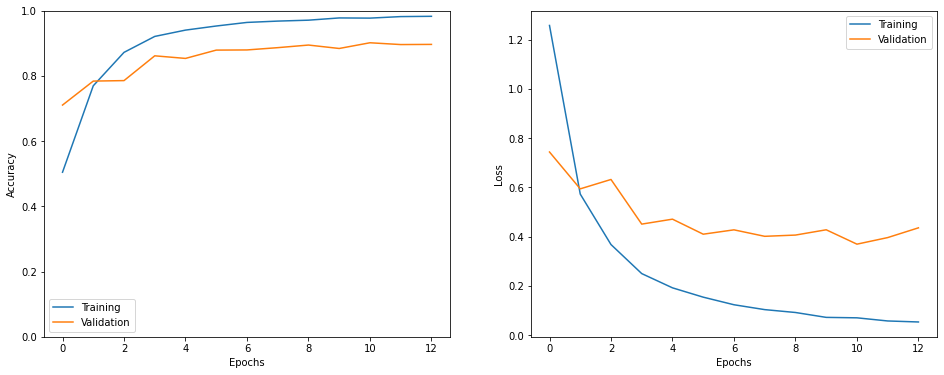

In [44]:
show_history(h)

In [47]:
test_tweets, test_labels=get_a_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels=names_to_ids(test_labels)

In [61]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.4338 - accuracy: 0.8930


In [62]:
i = random.randint(0, len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  ive blogged and i feel strange about it
Emotion:  surprise
Predicted Emotion:  fear


In [73]:
#model.predict_classes is no longer supported, an alternative is as 
#follows :
preds = np.argmax(model.predict(test_seq),axis=1)

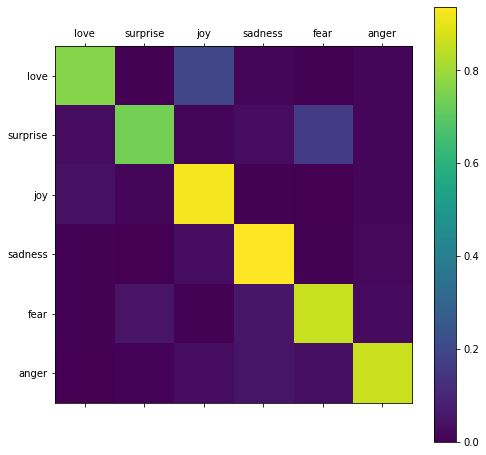

In [72]:
show_confusion_matrix(test_labels, preds, list(classes))